# Project Physics

In this text we will look, numerically, at the stability of a ship. For a ship to be able to sail across the ocean, it needs to have a certain amount of stability. This stability prevents it from capsizing from the forces that are bound to be affecting the ship on its tour. We will look at how different initial conditions, as well as other factors, such as waves, affects the stability of a ship.

To make the calculations accessible, we need to make simplifications of the ship. Firstly, we will make the problem 2-dimensional by only looking at a slice in the middle of the ship. This simplification does not affect the final result considerably, as it is safe to assume that the forces are close to constant throughout the ship, and our interest is in whether the ship will capsize.

In [56]:
import numpy as np
import matplotlib.pyplot as plt

First of, we need to define our ship. Our ship will be a half-circle with uniform mass (see figure 1**). We need several constants that we will use in the calculations:

In [57]:
R = 10 # Radius of the ship
H = 4 * R / (3 * np.pi) # The distance from the midpoint of the diameter to the center of mass
g = 9.81 # The gravitational acceleration
sigma0 = 1000 # The density of the water
sigma = 500 # The density of the ship

To do some calculations, we first need to identify the forces that act on the ship. We will start by assuming the center of mass stays in place, and the only movement will be a rotation of the ship. As a start, the forces analyzed will be restricted to the updraft of the water. This updraft will, by symmetry, be normal to the surface of the water. With the use of geometry one can find that the area subdued underwater is
$$A = \frac{1}{2}R^2(\gamma-\sin(\gamma))$$
Furthermore, we define the angle $\theta$ as the angle of rotation around the center of mass of the boat. This angle is defined positive counter-clockwise. With further geometry, it can be shown that the angle $\gamma$ can be expressed by $\theta$:
$$\gamma=2 \arccos{\left(\cos(\beta/2)-\frac{4}{3\pi}(1-\cos(\theta)\right)$$
where $\beta$ is the initial $\gamma$ when the ship is in equilibrium.

Now, the total updraft from the water is
$$F_B=A\sigma_0g$$
As a rotation of the ship will displace the center of mass from the center of the updraft force. This gives a torque that can be expressed as:
$$\tau_B = -F_Bh\sin(\theta)$$
It can also be shown that the moment of inertia of the ship around the center of mass is:
$$I_C = \frac{1}{2}mR^2-mH^2$$
Where H is the distance from the midpoint M (see figure 1) to the center of mass C.

We will now use Eulers method to simulate numerically the movement of the ship:

In [58]:
A0 = 1 / 2 * R ** 2 * np.pi * sigma / sigma0 # Area subdued underwater at equilibrium
m = A0 * sigma0 # Mass of the water that is displaced
I_M = 1 / 2 * m * R ** 2 # Moment of inertia of the midpoint M
I_C = I_M - m * H ** 2 # Moment of inertia of the center of mass
omega_0 = (m * g * H / I_C) ** 0.5 # ??

F_G = -m * g # ??

def F_B(A): # The updraft force
    return A * sigma0 * g

def tau_B(theta, A): #The torque from the updraft
    return -F_B(A) * H * np.sin(theta)

In [59]:
#Oppgave 1c)

def f(t, w):  # Function that defines the derivative of theta and w
    theta, omega = w
    tau = tau_B(theta, A0)
    return np.array([omega, tau / I_C])

In [60]:
def euler(f, x, y, h):
    y_next = y + h * f(x, y)
    x_next = x + h
    return x_next, y_next

In [61]:
def solve_ode(f, x0, xend, y0, h, method=euler):
    # Initializing:
    y_num = np.array([y0])  # Array for the solution y
    x_num = np.array([x0])  # Array for the x-values

    xn = x0  # Running values for x and y
    yn = y0

    # Main loop
    while xn < xend - 1.e-10:  # Buffer for truncation errors
        xn, yn = method(f, xn, yn, h)  # Do one step by the method of choice

        # Extend the arrays for x and y
        y_num = np.concatenate((y_num, np.array([yn])))
        x_num = np.append(x_num, xn)

    return x_num, y_num

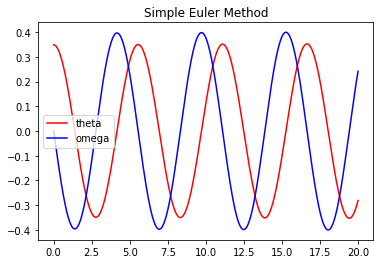

In [62]:
#Oppgave 1d)

t0 = 0
tend = 20
w0 = np.array([20 / 180 * np.pi, 0])
h = 0.001
t_num, w_num = solve_ode(f, t0, tend, w0, h, method=euler)
plt.title("Simple Euler Method")
plt.plot(t_num, w_num[:, 0], 'r')
plt.plot(t_num, w_num[:, 1], 'b')
plt.legend(['theta', 'omega'])
plt.show()

In [63]:
#Oppgave 1e)
def tau_B_approx(theta, A):
        return -F_B(A) * H * theta

def f_approx(t, w):  # Function that defines the derivative of theta and w
    theta, omega = w
    tau = tau_B_approx(theta, A0)
    return np.array([omega, tau / I_C])

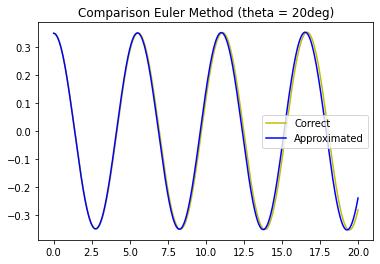

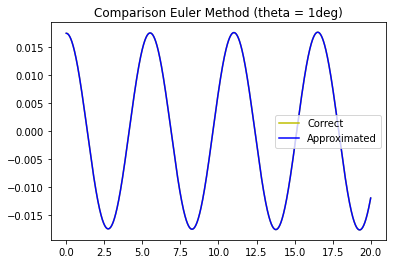

In [64]:
w0 = np.array([20 / 180 * np.pi, 0])
t_num, w_num = solve_ode(f, t0, tend, w0, h, method=euler)
t_num_approx, w_num_approx = solve_ode(f_approx, t0, tend, w0, h, method=euler)
plt.title("Comparison Euler Method (theta = 20deg)")
plt.plot(t_num, w_num[:, 0], 'y')
plt.plot(t_num_approx, w_num_approx[:, 0], 'b')
plt.legend(['Correct', 'Approximated'])
plt.show()

w0 = np.array([1 / 180 * np.pi, 0])
t_num, w_num = solve_ode(f, t0, tend, w0, h, method=euler)
t_num_approx, w_num_approx = solve_ode(f_approx, t0, tend, w0, h, method=euler)
plt.title("Comparison Euler Method (theta = 1deg)")
plt.plot(t_num, w_num[:, 0], 'y')
plt.plot(t_num_approx, w_num_approx[:, 0], 'b')
plt.legend(['Correct', 'Approximated'])
plt.show()

In [65]:
#Oppgave 1f)

def runge_kutta_4(f, x, y, h):
    k1 = f(x, y)
    k2 = f(x + h / 2, y + h / 2 * k1)
    k3 = f(x + h / 2, y + h / 2 * k2)
    k4 = f(x + h, y + h * k3)

    y_next = y + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
    x_next = x + h
    return x_next, y_next

In [66]:
#Oppgave 1g)

def analytic_solution(F_B, h, I, theta0):
    omega0 = np.sqrt(F_B * h / I)

    def theta(t):
        return theta0 * np.cos(omega0 * t)

    return theta

def compare_methods(t, f, t0, w0, h_array):
    w_analytic = analytic_solution(F_B(A0), H, I_C, w0)(t)

    euler_diff_array = np.array([calc_difference_at_t(t, euler, f, t0, w0, h, w_analytic) for h in h_array])
    rk4_diff_array = np.array([calc_difference_at_t(t, runge_kutta_4, f, t0, w0, h, w_analytic) for h in h_array])

    return euler_diff_array, rk4_diff_array


def calc_difference_at_t(t, method, f, t0, theta0, h, w_analytic):
    _, y = solve_ode(f, t0, t, theta0, h, method=method)
    return np.linalg.norm(y[-1] - w_analytic)

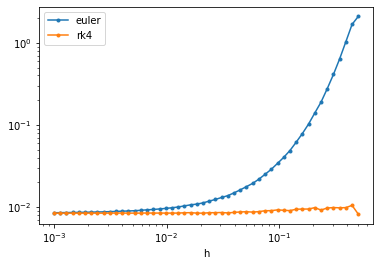

In [67]:
#Oppgave 1h)

def plot_difference(ax, h, difference, **plot_args):
    ax.plot(h, difference, marker=".", **plot_args)


def plot_differences(h, euler, rk4):
    _, ax = plt.subplots(1)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("h")

    plot_difference(ax, h, euler, label="euler")
    plot_difference(ax, h, rk4, label="rk4")

    ax.legend()
    plt.show()

h_array = np.exp(np.linspace(*np.log([0.001, 0.5])))  # Evenly spaced on a log-scaled x-axis
w0 = np.array([0.01, 0])
euler_diff_array, rk4_diff_array = compare_methods(t=20, f=f, t0=0, w0=w0, h_array=h_array)
plot_differences(h_array, euler_diff_array, rk4_diff_array)